In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import lib.assembly_graph
import lib.plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp

In [4]:
def build_from_seed(seed, depth):
    right, left = lib.assembly_graph.build_full_from_seed_graph(seed)
    depth = pd.Series(lib.assembly_graph.add_reverse_complement_depth(depth)).astype(float)
    assert (depth.index.isin(right.keys()) | depth.index.isin(left.keys())).all()
    dgraph = pd.DataFrame(np.zeros((len(depth), len(depth))), index=depth.index, columns=depth.index)
    for unitig in depth.index:
        dgraph.loc[unitig, right[unitig]] = 1
    return dgraph, depth

In [5]:
def initialize_messages(dgraph, depth):
    # Step -1
    send_to_r = dgraph
    send_to_l = dgraph.T
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)

    # Step 0
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)

    return send_to_r, send_to_l

In [6]:
def iterate_messages(send_to_r, send_to_l, depth, gamma=1.0):
    total_from_l = send_to_r.sum()
    total_from_r = send_to_l.sum()
    # Update depth
    next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
    # Scale the depth so there's no overall loss.
    depth = next_depth * (depth.sum() / next_depth.sum())
    # Calculate next message
    send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
    send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T
    send_to_r = send_to_r_next.fillna(0)
    send_to_l = send_to_l_next.fillna(0)
    return send_to_r, send_to_l, depth

# Tall saw-horse

Converged on iteration 14


AACCG    10.442286
CGGTT    10.442286
ACCGG    13.397458
CCGGT    13.397458
CCGGG    10.442286
CCCGG    10.442286
CCGGA     1.160254
TCCGG     1.160254
TACCG     1.160254
CGGTA     1.160254
TAACC     6.028858
GGTTA     6.028858
TTACC     0.669873
GGTAA     0.669873
CGGGT     6.028858
ACCCG     6.028858
CGGAT     0.669873
ATCCG     0.669873
dtype: float64

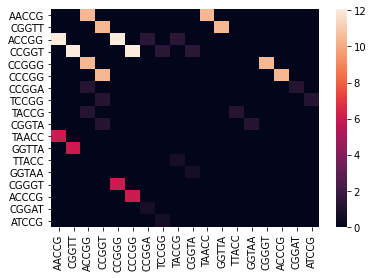

In [24]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
    'TAACC': ['AACCG'],
    'TTACC': ['TACCG'],
    'CCGGG': ['CGGGT'],
    'CCGGA': ['CGGAT'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 9,
    'ACCGG': 10,
    'CCGGG': 9,
    'CCGGA': 1,
    'TACCG': 1,
    'TAACC': 9,
    'TTACC': 1,
    'CGGGT': 9,
    'CGGAT': 1,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)
depth

Converged on iteration 7


AACCG    2.636039
CGGTT    2.636039
ACCGG    4.970562
CCGGT    4.970562
CCGGG    2.636039
CCCGG    2.636039
CCGGA    0.878680
TCCGG    0.878680
TACCG    0.878680
CGGTA    0.878680
dtype: float64

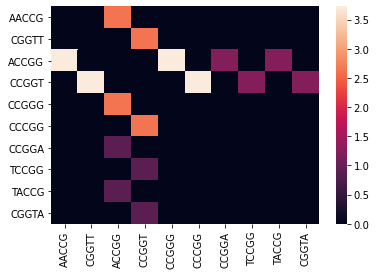

In [26]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 3,
    'ACCGG': 4,
    'CCGGG': 3,
    'CCGGA': 1,
    'TACCG': 1,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)
depth

# Saw-horse

# Cycle w/ Switch-back

In [9]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGT'],
    'CCGGT': ['CGGTA'],
    'CGGTA': ['GGTAC'],
    'GGTAC': ['GTACC'],
    'GTACC': ['TACCC'],
    'TACCC': ['ACCCG'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGT': 1,
    'CGGTA': 1,
    'GGTAC': 1,
    'GTACC': 1,
    'TACCC': 1,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)
depth

Converged on iteration 35


ACCCG    0.857148
CGGGT    0.857148
CCCGG    0.857151
CCGGG    0.857151
CCGGT    0.857148
ACCGG    0.857148
CGGTA    0.857141
TACCG    0.857141
GGTAC    1.714272
GTACC    1.714272
TACCC    0.857141
GGGTA    0.857141
dtype: float64

# Six-Cycle

Converged on iteration 26


ACCCG    1.166664
CGGGT    1.166664
CCCGG    1.166670
CCGGG    1.166670
CCGGA    1.166673
TCCGG    1.166673
CGGAC    1.166670
GTCCG    1.166670
GGACC    1.166664
GGTCC    1.166664
GACCC    1.166661
GGGTC    1.166661
dtype: float64

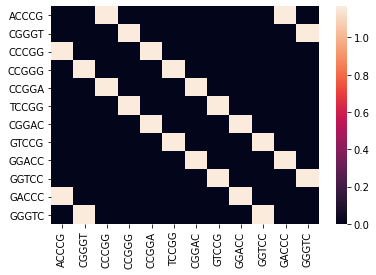

In [30]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    'CGGAC': ['GGACC'],
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG']
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 2,
    'CGGAC': 1,
    'GGACC': 1,
    'GACCC': 1,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)
depth

# Six-cycle w/ Spur

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
Converged on iteration 43


ACCCG    1.166674
CGGGT    1.166674
CCCGG    1.166671
CCGGG    1.166671
CCGGA    1.166656
TCCGG    1.166656
CGGAC    1.166657
GTCCG    1.166657
GGACC    1.166664
GGTCC    1.166664
GACCC    1.166671
GGGTC    1.166671
CCGGC    0.000007
GCCGG    0.000007
dtype: float64

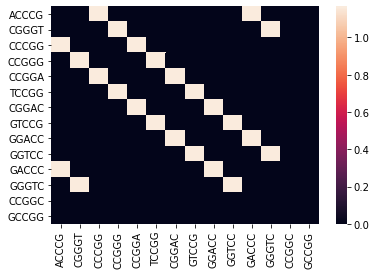

In [39]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA', 'CCGGC'],
    'CCGGA': ['CGGAC'],
    'CGGAC': ['GGACC'],
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG']
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 1,
    'CGGAC': 1,
    'GGACC': 1,
    'GACCC': 1,
    'CCGGC': 1,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)
depth

# Double-six-cycle

Converged on iteration 0


GGACC    1.0
GGTCC    1.0
GACCC    1.0
GGGTC    1.0
ACCCG    1.0
CGGGT    1.0
CCCGG    1.0
CCGGG    1.0
CCGGA    1.0
TCCGG    1.0
CGGAC    3.0
GTCCG    3.0
GGACT    2.0
AGTCC    2.0
GACTC    2.0
GAGTC    2.0
ACTCG    2.0
CGAGT    2.0
CTCGG    2.0
CCGAG    2.0
TCGGA    2.0
TCCGA    2.0
dtype: float64

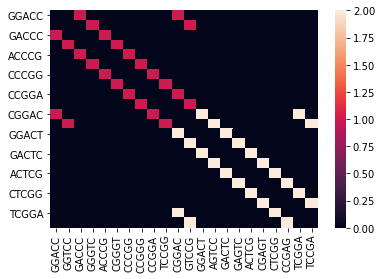

In [28]:
seed = {
    # Top cycle
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG'],
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    
    # Link
    'CGGAC': ['GGACC', 'GGACT'],
    
    # Bottom cycle
    'GGACT': ['GACTC'],
    'GACTC': ['ACTCG'],
    'ACTCG': ['CTCGG'],
    'CTCGG': ['TCGGA'],
    'TCGGA': ['CGGAC'],
    
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    # Top cycle
    'GGACC': 1,
    'GACCC': 1,
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 1,
    
    # Link
    'CGGAC': 3,
    
    # Bottom 
    'GGACT': 2, 
    'GACTC': 2,
    'ACTCG': 2,
    'CTCGG': 2,
    'TCGGA': 2,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)
depth

# Lonely-stick

Converged on iteration 1


GGACC    1.5
GGTCC    1.5
GACCT    1.5
AGGTC    1.5
dtype: float64

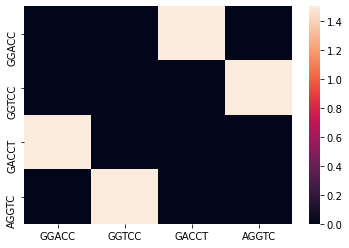

In [29]:
seed = {
    # Top cycle
    'GGACC': ['GACCT'],
}
observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    # Top cycle
    'GGACC': 1,
    'GACCT': 2,
})
dgraph, depth0 = build_from_seed(seed, observed_depth)
send_to_r, send_to_l = initialize_messages(dgraph, depth0)

depth = depth0
thresh = 1e-5
i = 0
while True:
    send_to_r, send_to_l, new_depth = iterate_messages(send_to_r, send_to_l, depth)
    delta = new_depth - depth
    change = np.sqrt(np.sum(np.square(new_depth - depth)))
    depth = new_depth
    if change < thresh:
        print(f"Converged on iteration {i}")
        break
    i += 1
    
sns.heatmap(send_to_r + send_to_l)
depth